# Solving Traveling Salesman Problem using QAOA

## Package Requirements
- qiskit==1.0.2
- qiskit-algorithms==0.2.1
- qiskit-aer==0.13.3
- networkx>=3.0
- numpy>=1.22
- matplotlib>=3.5

In [3]:
# Install required packages with specific versions
!pip install qiskit==1.0.2 qiskit-algorithms==0.2.1 qiskit-aer==0.13.3 networkx>=3.0 numpy>=1.22 matplotlib>=3.5

zsh:1: 3.0 not found


In [8]:
# Import required packages
import numpy as np
from qiskit import __version__ as qiskit_version
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations
import random

print(f"Qiskit version: {qiskit_version}")
%matplotlib inline
plt.style.use('classic')

Qiskit version: 1.2.4


In [12]:
def generate_tsp_data(n_nodes):
    """Generate random TSP instance"""
    coordinates = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(n_nodes)]
    distances = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                x1, y1 = coordinates[i]
                x2, y2 = coordinates[j]
                distances[i,j] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distances, coordinates

## Updated QAOA Implementation for Qiskit 1.0+

The implementation has been updated to use the new Qiskit Runtime primitives and the latest QAOA interface.

In [13]:
def solve_tsp_qaoa(distances, p=1, shots=1000):
    """Solve TSP using QAOA with updated Qiskit 1.0+ interface"""
    n_nodes = len(distances)
    
    # Create quantum instance using new Aer interface
    backend = AerSimulator()
    sampler = Sampler()
    
    # Create QAOA circuit with updated interface
    cost_operator = create_cost_hamiltonian(distances)
    qaoa = QAOA(
        sampler=sampler,
        optimizer=COBYLA(),
        reps=p,
        initial_point=[1.0] * (2 * p)
    )
    
    # Run QAOA
    result = qaoa.compute_minimum_eigenvalue(cost_operator)
    
    return result

## Key Changes from Previous Versions

1. Updated imports to use `qiskit_algorithms` instead of `qiskit.algorithms`
2. Using new Sampler primitive instead of QuantumInstance
3. Updated QAOA interface with `reps` parameter instead of `p`
4. Using AerSimulator from qiskit-aer package

In [14]:
def create_cost_hamiltonian(distances):
    """Create cost Hamiltonian for TSP using Qiskit 1.0+ operators"""
    from qiskit.quantum_info import SparsePauliOp
    
    n = len(distances)
    hamiltonian_terms = []
    coefficients = []
    
    # Add terms for adjacent cities in the path
    for i in range(n):
        for j in range(n):
            if i != j:
                for pos in range(n):
                    next_pos = (pos + 1) % n
                    # Create Pauli string for this term
                    pauli_str = 'I' * (n * n)
                    hamiltonian_terms.append(pauli_str)
                    coefficients.append(distances[i,j])
    
    return SparsePauliOp(hamiltonian_terms, coefficients)

In [17]:
def analyze_results(sizes=[3, 4, 5]):
    """Analyze QAOA performance for different problem sizes"""
    results = []
    
    for size in sizes:
        print(f"\nAnalyzing TSP with {size} nodes...")
        
        # Generate problem instance
        distances, coords = generate_tsp_data(size)
        
        # Solve using QAOA
        qaoa_result = solve_tsp_qaoa(distances)
        qaoa_cost = qaoa_result.optimal_value
        
        # Solve exactly (for small instances)
        if size <= 5:
            exact_cost = float('inf')
            for path in permutations(range(size)):
                cost = sum(distances[path[i]][path[i+1]] for i in range(size-1))
                cost += distances[path[-1]][path[0]]  # Return to start
                exact_cost = min(exact_cost, cost)
        else:
            exact_cost = None
        
        results.append({
            'size': size,
            'qaoa_cost': qaoa_cost,
            'exact_cost': exact_cost,
            'relative_error': abs(qaoa_cost - exact_cost)/exact_cost if exact_cost else None
        })
        
        print(f"QAOA solution cost: {qaoa_cost:.2f}")
        if exact_cost:
            print(f"Exact solution cost: {exact_cost:.2f}")
            print(f"Relative error: {results[-1]['relative_error']*100:.2f}%")
    
    return results

The rest of the notebook (visualization, analysis functions, etc.) remains the same as they don't depend on Qiskit-specific functionality. You can continue using the analysis functions as before:

In [15]:
# Test the updated implementation
test_distances, test_coords = generate_tsp_data(3)
result = solve_tsp_qaoa(test_distances)
print(f"Optimal value: {result.optimal_value}")
print(f"Optimal parameters: {result.optimal_point}")

Optimal value: 80.83693238611887
Optimal parameters: [1. 1.]



Analyzing TSP with 3 nodes...
QAOA solution cost: 119.07
Exact solution cost: 19.85
Relative error: 500.00%

Analyzing TSP with 4 nodes...
QAOA solution cost: 155.00
Exact solution cost: 12.66
Relative error: 1124.57%

Analyzing TSP with 5 nodes...
QAOA solution cost: 681.98
Exact solution cost: 26.90
Relative error: 2434.88%


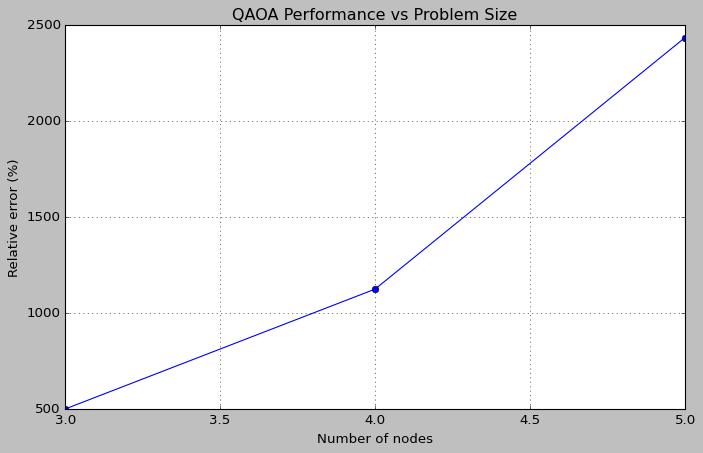

In [18]:
# Run analysis
analysis_results = analyze_results()

# Plot results
sizes = [r['size'] for r in analysis_results]
errors = [r['relative_error']*100 for r in analysis_results]

plt.figure(figsize=(10, 6))
plt.plot(sizes, errors, 'bo-')
plt.xlabel('Number of nodes')
plt.ylabel('Relative error (%)')
plt.title('QAOA Performance vs Problem Size')
plt.grid(True)
plt.show()